# CFL Code In-Depth Example
In this example, we will:

    1) set up a CFL pipeline that takes visual bars data as input,
    2) tune the hyperparameters for all models in the pipeline
    3) visualize the results

While CFL has built-in support for tuning `CauseClusterer` and `EffectClusterer`
hyperparameters, we must use Optuna (or a similar neural network tuning package) 
to tune the `CondDensityEstimator` neural network hyperparameters. For this 
reason, we will setup one CFL pipeline for tuning hyperparameters for the 
`CondDensityEstimator` with Optuna first, and then setup a second pipeline that 
trains the `CondDensityEstimator` with the optimal hyperparameters found by the 
first pipeline and then tunes and trains the `CauseClusterer` and 
`EffectClusterers`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# cfl imports
from cfl import Experiment
from visual_bars.generate_visual_bars_data import VisualBarsData
from cfl.visualization.basic_visualizations import visualize_macrostates

# hyperparameter optimization
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from keras import Sequential
from keras.layers import Dense, Dropout

### 1. Load Data
We will use the VisualBarsData class to generate a toy visual bars dataset.
The process used to generate this data is described in the visual bars tutorial. 
To keep things simple, we will flatten the cause images from 10x10 images to 
100-dimensional vectors so that we can use a standard feedforward neural
network for conditional density estimation instead of a convolutional neural
network (though this would likely improve performance). 

X raw shape:  (5000, 10, 10)
Y raw shape:  (5000,)


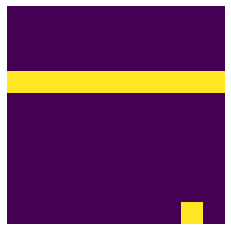

X final shape:  (5000, 100)
Y final shape:  (5000, 1)


In [2]:
# instantiate `VisualBarsData` object
vb_data = VisualBarsData(n_samples=5000, im_shape=(10, 10), 
                         noise_lvl=0.03, set_random_seed=42)

# retrieve the images and the target 
X = vb_data.getImages()
Y = vb_data.getTarget()
print('X raw shape: ', X.shape)
print('Y raw shape: ', Y.shape)

# visualize an example sample
plt.imshow(X[22])
plt.axis('off')
plt.show()

# vectorize X images and make Y images 2D to be cfl-compatible
X = np.reshape(X, (X.shape[0], np.product(X.shape[1:])))
Y = np.expand_dims(Y, -1)
print('X final shape: ', X.shape)
print('Y final shape: ', Y.shape)

# define DATA_INFO, which must be passed into our CFL Experiment
DATA_INFO = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'categorical'}

# define indices for training and valadation subsets of the data so that
# we can evaluate various hyperparameters on the same withheld subset
IN_SAMPLE_IDX,OUT_SAMPLE_IDX = train_test_split(np.arange(X.shape[0]),
                                                 train_size=0.75,
                                                 random_state=42)

### 2. Tune hyperparameters for CondDensityEstimator
The first step in defining our CFL pipeline is to learn optimal hyperparameters
for the conditional density estimator. To simplify the problem of learning
a conditional distribution, we will estimate the expectation of this distribution
instead. A conditional expectation estimator can be specified through `cfl` with
a `CondExpDIY` model. 

To tune the hyperparameters for this model, we will use the Optuna library. 
Detailed instructions on using Optuna can be found in the Optuna tutorial or
in their documentation. The basic idea is to 1. specify your neural network
for a given set of hyperparameter values, 2. define an objective function 
that computes a measure of how good this network is for a given set of hyperparameter
values, 3. run an optuna study that will smartly iterate over many hyperarameter
value combinations.

In [3]:
# 1. build a function that will define our neural network

def build_network(trial):
    # vary number of layers
    n_layers = trial.suggest_int("n_layers", 1, 3)
    model = Sequential()
    
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 256, log=True)
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = trial.suggest_float("dropout_l{}".format(i), 0.0, 0.5)
        model.add(Dropout(rate=dropout))

    # add output layer with size of target    
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

In [4]:
# 2. define an objective function that evaluates a given network's performance
def objective(trial):
    CDE_params = {
        'model'           : 'CondExpDIY',
        'verbose' : 1,
        'model_params'    : {
            # specify our function from step 1 for building the network
            'build_network'     : build_network,
            # add a callback that automatically stops training early for 
            # hyperparameter value combinations that look not promising
            'optuna_callback' : TFKerasPruningCallback(trial, "val_loss"),
            # provide the `trial` object, which specifies hyperparameter
            # combinations for the current study iteration
            'optuna_trial'    : trial,
            # network training hyperparameters
            'batch_size'      : trial.suggest_int("batch_size", 16, 128),
            'n_epochs'        : 100,
            'optimizer'       : 'adam',
            'opt_config'      : {'lr' : trial.suggest_float("lr", 1e-5, 1e-3, log=True)},
            'loss'            : 'mean_squared_error',
            'best'            : True, 
            'early_stopping'  : True,
            'verbose'         : 0,
        },
    }

    # for now, we will specify an Experiment that only contains a
    # CondDensityEstimator, since we don't need to know clustering results
    # in order to evaluate how good a given CondDensityEstimator network is
    my_exp = Experiment(X_train=X, 
                        Y_train=Y, 
                        in_sample_idx=IN_SAMPLE_IDX,
                        out_sample_idx=OUT_SAMPLE_IDX,
                        data_info=DATA_INFO, 
                        block_names=['CondDensityEstimator'], 
                        block_params=[CDE_params], 
                        verbose=0,
                        results_path=None) # we don't want to save 100's of results

    # train the CFL pipeline and take the minimum validation loss from the
    # CondDensityEstimator training as our evaluation metric
    train_results = my_exp.train()     
    score = np.min(train_results['CondDensityEstimator']['val_loss'])
    return score

[I 2022-03-23 17:20:59,261] A new study created in memory with name: no-name-f6fb7154-40d7-4fe6-91b4-54a3d2df53a5


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

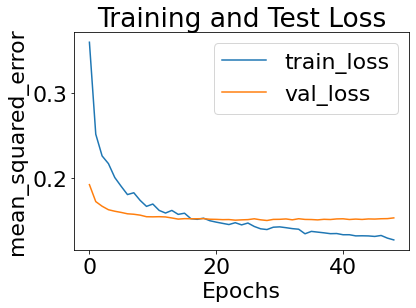

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


[I 2022-03-23 17:21:10,778] Trial 0 finished with value: 0.1501224786043167 and parameters: {'batch_size': 70, 'lr': 0.0004469301425517348, 'n_layers': 1, 'n_units_l0': 48, 'dropout_l0': 0.24737793557393845}. Best is trial 0 with value: 0.1501224786043167.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

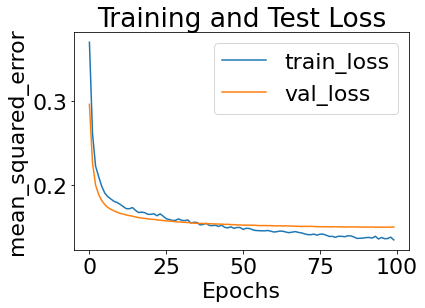

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


[I 2022-03-23 17:21:32,525] Trial 1 finished with value: 0.14899791777133942 and parameters: {'batch_size': 72, 'lr': 3.691282812195019e-05, 'n_layers': 1, 'n_units_l0': 159, 'dropout_l0': 0.09148617746139015}. Best is trial 1 with value: 0.14899791777133942.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

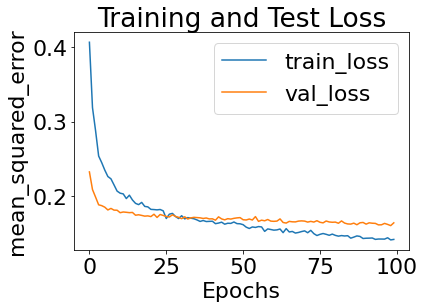

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


[I 2022-03-23 17:22:15,020] Trial 2 finished with value: 0.16023316979408264 and parameters: {'batch_size': 61, 'lr': 0.00020870803053454806, 'n_layers': 2, 'n_units_l0': 50, 'dropout_l0': 0.30642245072016777, 'n_units_l1': 22, 'dropout_l1': 0.2054317561537234}. Best is trial 1 with value: 0.14899791777133942.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

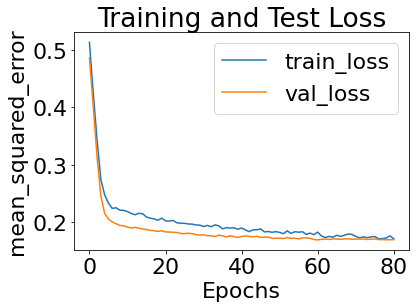

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


[I 2022-03-23 17:22:49,291] Trial 3 finished with value: 0.1694500744342804 and parameters: {'batch_size': 48, 'lr': 4.8197525706368465e-05, 'n_layers': 3, 'n_units_l0': 64, 'dropout_l0': 0.4597960452158009, 'n_units_l1': 6, 'dropout_l1': 0.0992273678564991, 'n_units_l2': 199, 'dropout_l2': 0.290903942636899}. Best is trial 1 with value: 0.14899791777133942.


Study statistics: 
  Number of finished trials:  4
  Number of pruned trials:  0
  Number of complete trials:  4
Best trial:
  Value:  0.14899791777133942
  Params: 
    batch_size: 72
    lr: 3.691282812195019e-05
    n_layers: 1
    n_units_l0: 159
    dropout_l0: 0.09148617746139015


In [5]:
# 3. Run an Optuna study, trying 4 different hyperparameter combinations
#    (We only try a few trials here to keep the notebook short. Depending
#    on how many hyperparameters you're tuning, you should significantly
#    increase the number of trials.)
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=4)

# print out tuning results
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

### 3. Specify CondDensityEstimator with optimal hyperparameters
Now that we have the optimal hyperparameters (store in the
`study.best_trial.params` dictionary), we can rebuild our network with these
specific hyperparameters and specify the function that does this into the 
parameters for the `CondDensityEstimator`. These are the hyperparameters we
will use in our full run of CFL (at which point we will tune the `CauseClusterer`
and `EffectClusterer` as well).

In [6]:
def build_optimized_network():
    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target    
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

opt_CDE_params = {
    'model'        : 'CondExpDIY',
    'model_params' : {
        'build_network'   : build_optimized_network,
        'batch_size'      : study.best_trial.params['batch_size'],
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'opt_config'      : {'lr' : study.best_trial.params['lr']},
        'loss'            : 'mean_squared_error',
        'best'            : True, 
        'verbose'         : 0,
        'early_stopping'  : True
    }
}  

### 4. Tune hyperparameters for CauseClusterer and EffectClusterer and train
To tune the `CauseClusterer` and `EffectClusterer`, we need to 

1. set 'tune' to True in the parameter dictionary, and
2. specify ranges of hyperparameters to iterate over instead of single values

Once we do this, CFL will retrain the clustering model for each combination
of hyperparameters specified, and display a plot evaluating how good the
model is with each set of hyperparameters. Specifically, it evaluates how 
well the conditional distribution that was learned by the `CondDensityEstimator`
can be predicted from the cluster assignments found. From this plot, you can
select the "elbow" where the error stops significantly dropping. This is the point
at which finer grained clusters are more likely overfitting than truly describing
distinct conditional probability regions for this dataset. 

CFL will then prompt you to enter your chosen hyperparameters from the error plot,
and will retrain with these final hyperparameters.

save_path 'demo_results' doesn't exist, creating now.
All results from this run will be saved to demo_results/experiment0000
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbos

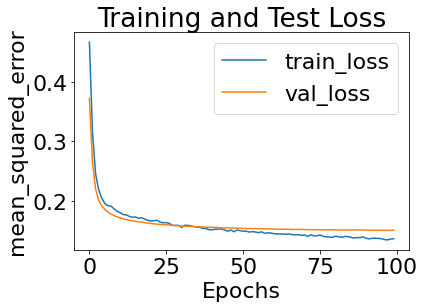

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


0it [00:00, ?it/s]

CondDensityEstimator training complete.
Beginning CauseClusterer training...
Beginning clusterer tuning


9it [00:07,  1.27it/s]


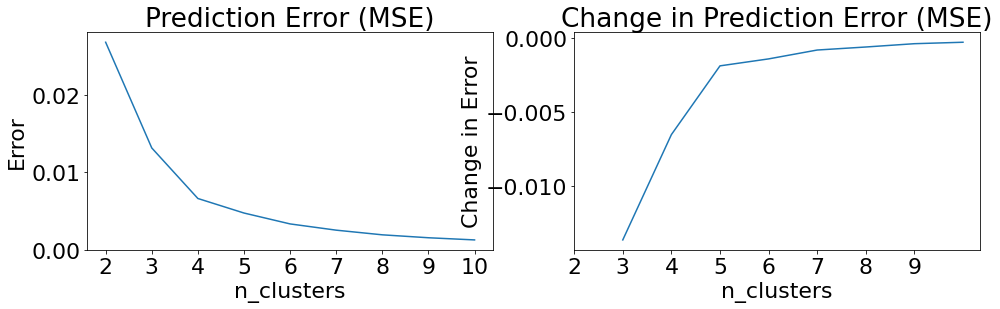

Please choose your final clustering parameters.
Final parameters:  {'n_clusters': 4}
CauseClusterer training complete.
Beginning EffectClusterer training...


0it [00:00, ?it/s]

Beginning clusterer tuning


1it [00:00,  3.46it/s]/Users/imanwahle/Desktop/cfl/cfl/clustering/cluster_tuning_util.py:173: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  tmp_model.fit(data_to_cluster)
2it [00:00,  3.45it/s]/Users/imanwahle/Desktop/cfl/cfl/clustering/cluster_tuning_util.py:173: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  tmp_model.fit(data_to_cluster)
3it [00:01,  2.78it/s]/Users/imanwahle/Desktop/cfl/cfl/clustering/cluster_tuning_util.py:173: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  tmp_model.fit(data_to_cluster)
4it [00:01,  2.77it/s]


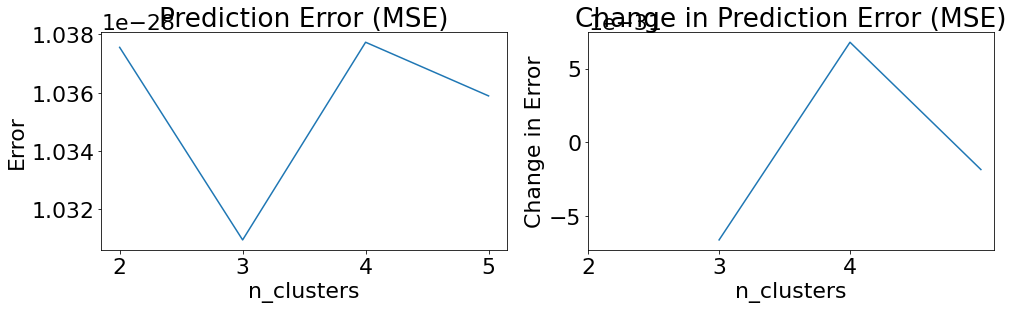

Please choose your final clustering parameters.
Final parameters:  {'n_clusters': 2}
EffectClusterer training complete.
Experiment training complete.


In [7]:
cause_clusterer_params = { 'model' : 'KMeans', 
                           'model_params' : {'n_clusters' : np.arange(2, 11, dtype=int)},
                           'tune' : True,
                           'verbose' : 0 }
effect_clusterer_params = {'model' : 'KMeans', 
                           'model_params' : {'n_clusters' : np.arange(2, 6, dtype=int)},
                           'tune' : True,
                           'precompute_distance' : True,
                           'verbose' : 0 }
block_names = ['CondDensityEstimator', 'CauseClusterer', 'EffectClusterer']
block_params = [opt_CDE_params, cause_clusterer_params, effect_clusterer_params]

my_exp = Experiment(X_train=X, 
                    Y_train=Y, 
                    data_info=DATA_INFO, 
                    in_sample_idx=IN_SAMPLE_IDX, 
                    out_sample_idx=OUT_SAMPLE_IDX,
                    block_names=block_names, 
                    block_params=block_params, 
                    results_path='demo_results')

train_results = my_exp.train()   

Above, we see that the error plot for the CauseClusterer clearly decreases
in improvement as n_clusters = 4. 
For the EffectClusterer, we see that KMeans throws warnings that the number
of distinct clusters found is 2, as opposed to the larger numbers of clusters
we ask for. For this reason, we select n_clusters = 2 even though it is not
evident from the error plot.

### 5. Visualize results
We will plot a few examples from each cause macrostate to see what high-level
features each macrostate specifies for. 
For more general visualization methods, refer to the 
[Macrostate Visualization](https://cfl.readthedocs.io/en/latest/examples/basic_visualizations.html)
notebook.

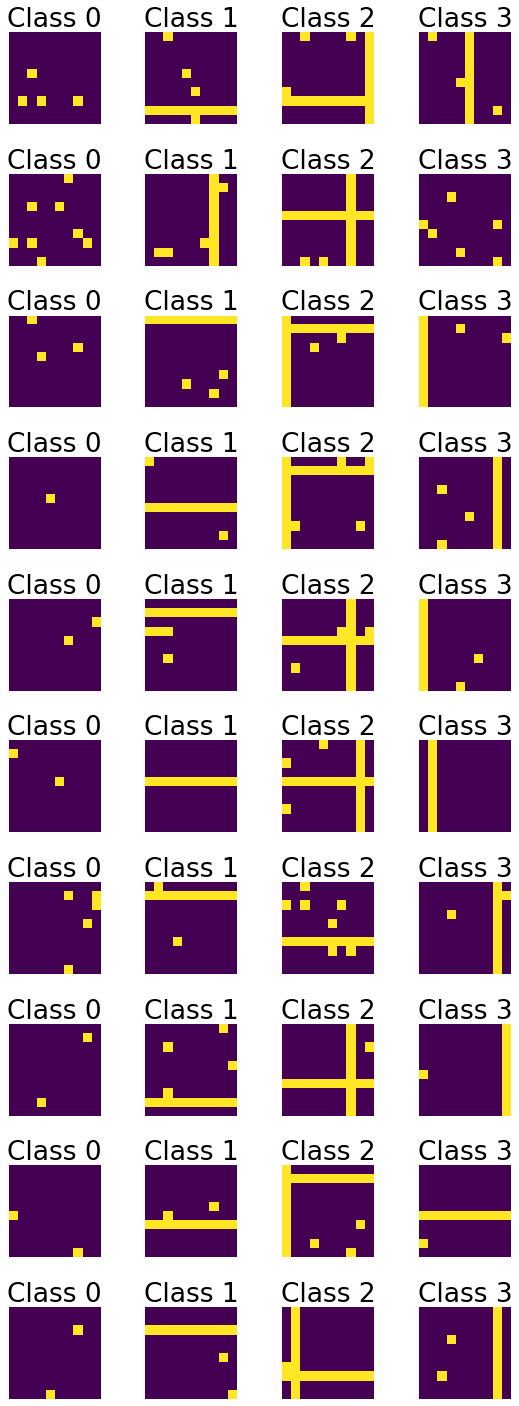

In [8]:
from visual_bars.visual_bars_vis import viewImagesAndLabels
viewImagesAndLabels(X, im_shape=(10,10), n_examples=10, 
                    x_lbls=train_results['CauseClusterer']['x_lbls'])

Since Y is just a binary variable, we can print out the percent of samples
where Y=1 in each effect macrostate:

In [9]:
ylbls = train_results['EffectClusterer']['y_lbls']
print('% Y=1 for effect macrostate 0:', np.sum(Y[ylbls==0]==1)/np.sum(ylbls==1))
print('% Y=1 for effect macrostate 1:', np.sum(Y[ylbls==1]==1)/np.sum(ylbls==1))

% Y=1 for effect macrostate 0: 0.0
% Y=1 for effect macrostate 1: 1.0


While this seems like a somewhat trivial situation to have partitioned
the effect space (which is just described by a binary variable), the fact that
CFL partitions based on the relation between X and Y (instead of just
clustering based on the effect space here) makes it so that we could've gotten 
a very different partition of the effect space if, for example, P(Y=1 | X) = P(Y=0 | X).